# Importación de librerías y carga de datos

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm

from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster, backtesting_forecaster, random_search_forecaster
from skforecast.utils import save_forecaster
from skforecast.plot import plot_residuals

import warnings
warnings.filterwarnings('ignore')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
demand = pd.read_csv('C:\\Users\\rasel\\PycharmProjects\\Time_Series _Forecasting\\dataset\\historic_demand_2009_2023_noNaN.csv')

# Análisis exploratorio

In [3]:
# Tipo de cada columna del dataset historic_demand_2009_2023_noNaN.csv
# Se comprueban los tipos de columnas, la cantidad de ellas, el total de los datos, entre otras características del dataset.

demand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250194 entries, 0 to 250193
Data columns (total 19 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   settlement_date            250194 non-null  object
 1   settlement_period          250194 non-null  int64 
 2   period_hour                250194 non-null  object
 3   nd                         250194 non-null  int64 
 4   tsd                        250194 non-null  int64 
 5   england_wales_demand       250194 non-null  int64 
 6   embedded_wind_generation   250194 non-null  int64 
 7   embedded_wind_capacity     250194 non-null  int64 
 8   embedded_solar_generation  250194 non-null  int64 
 9   embedded_solar_capacity    250194 non-null  int64 
 10  non_bm_stor                250194 non-null  int64 
 11  pump_storage_pumping       250194 non-null  int64 
 12  ifa_flow                   250194 non-null  int64 
 13  ifa2_flow                  250194 non-null  

In [4]:
# Las columnas "period_hour" y "settlement_date" fueron almacenadas como string, se le cambia el tipo a datetime con la función
# to_datetime de la librería "pandas". Esta última columna se establece como índice, como los datos fueron registrados 
# cada 30 minutos, se establece la frecuencia de 30 minutos y se llenan posibles espacios vacíos con el valor existente anterior
# Se ordena el dataset por índice y se muestran

demand['period_hour'] = pd.to_datetime(demand['period_hour'])
demand['settlement_date'] = pd.to_datetime(demand['settlement_date'], format='%Y-%m-%dT%H:%M:%S')
demand = demand.set_index('settlement_date')
demand = demand.asfreq(freq='30min', method='ffill')
demand = demand.sort_index()
demand.index

DatetimeIndex(['2009-01-01 00:00:00', '2009-01-01 00:30:00',
               '2009-01-01 01:00:00', '2009-01-01 01:30:00',
               '2009-01-01 02:00:00', '2009-01-01 02:30:00',
               '2009-01-01 03:00:00', '2009-01-01 03:30:00',
               '2009-01-01 04:00:00', '2009-01-01 04:30:00',
               ...
               '2023-04-25 19:00:00', '2023-04-25 19:30:00',
               '2023-04-25 20:00:00', '2023-04-25 20:30:00',
               '2023-04-25 21:00:00', '2023-04-25 21:30:00',
               '2023-04-25 22:00:00', '2023-04-25 22:30:00',
               '2023-04-25 23:00:00', '2023-04-25 23:30:00'],
              dtype='datetime64[ns]', name='settlement_date', length=250944, freq='30T')

In [5]:
# Comprobación de número de datos ausentes por columna

demand.isna().sum().sort_values()

settlement_period            0
east_west_flow               0
moyle_flow                   0
britned_flow                 0
ifa2_flow                    0
ifa_flow                     0
pump_storage_pumping         0
non_bm_stor                  0
embedded_solar_capacity      0
embedded_solar_generation    0
embedded_wind_capacity       0
embedded_wind_generation     0
england_wales_demand         0
tsd                          0
nd                           0
period_hour                  0
nemo_flow                    0
is_holiday                   0
dtype: int64

# División de train y test

In [6]:
# La evaluación de la capacidad predictiva de un modelo consiste en comprobar que tan cercanas son sus predicciones 
# a los valores reales de la variable objetivo. Para poder cuantificarlo de forma correcta, se necesita disponer de 
# un conjunto de observaciones, de las que se conozca la variable respuesta, pero que el modelo no haya "visto". 
# Para lograrlo se dividen los datos disponibles en un conjunto de entrenamiento y un conjunto de prueba. El tamaño adecuado 
# de las particiones depende en gran medida de la cantidad de datos disponibles y la seguridad que se necesite en la estimación
# del error, 80%-20% suele dar buenos resultados.
# Suponiendo que el conjunto de prueba ('2023-01-01 00:00:00' - '2023-04-25 23:30:00') ==> 4 meses es el 20%, 
# el calculo del 80% tiene como resultado el siguiente espacio temporal ('2021-09-01 00:00:00' - '2023-01-01 00:00:00') ==> 16 meses.

demand_train = demand['2021-09-01 00:00:00':'2023-01-01 00:00:00']  
demand_test = demand['2023-01-01 00:00:00':'2023-04-25 23:30:00'] 
print("Fechas train : {} --- {}  (n={}) (80%)".format('2021-09-01 00:00:00', '2023-01-01 00:00:00', len(demand_train)))
print("Fechas test  : {} --- {}  (n={}) (20%)".format('2023-01-01 00:00:00', '2023-04-25 23:30:00', len(demand_test)))

Fechas train : 2021-09-01 00:00:00 --- 2023-01-01 00:00:00  (n=23377) (80%)
Fechas test  : 2023-01-01 00:00:00 --- 2023-04-25 23:30:00  (n=5520) (20%)


# Comprobación visual 

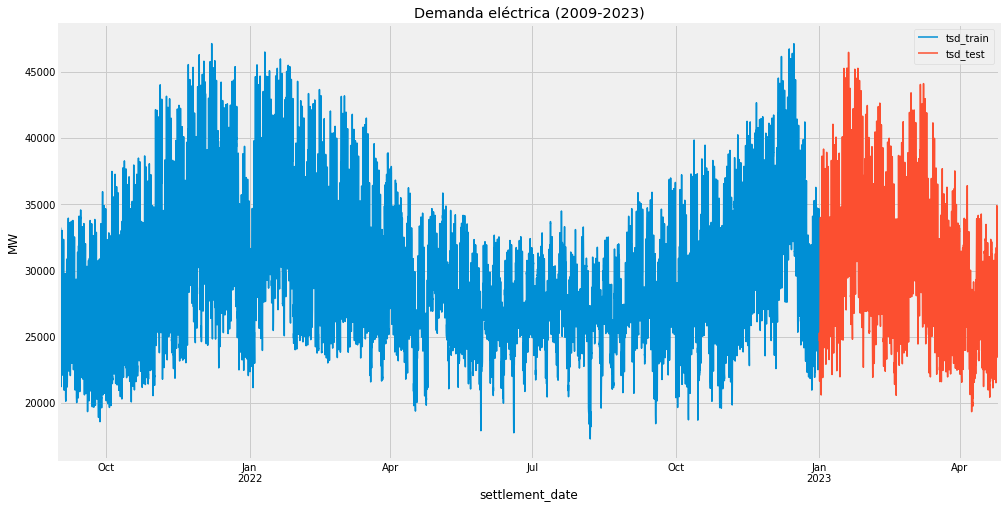

In [7]:
# Es de suma importancia hacer una representación gráfica de la serie temporal 
# porque permite identificar patrones como tendencias de estacionalidad y correlación de los datos.

# gráfica

fig, ax = plt.subplots(figsize=(15, 8))
demand_train['tsd'].plot(ax=ax, label='tsd_train')
demand_test['tsd'].plot(ax=ax, label='tsd_test')
ax.set_title('Demanda eléctrica (2009-2023)')
ax.set_ylabel('MW')
ax.legend();

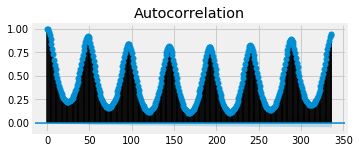

In [8]:
# Gráfico de autocorrelación

fig, ax = plt.subplots(figsize=(5, 2))
plot_acf(demand.tsd, ax=ax, lags=336)
plt.show()

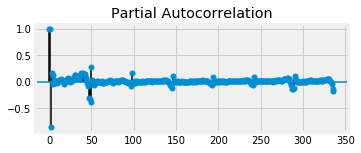

In [9]:
# Gráfico de autocorrelación parcial

fig, ax = plt.subplots(figsize=(5, 2))
plot_pacf(demand.tsd, ax=ax, lags=336)
plt.show()

# Conclusión de comprobación visual

In [10]:
# Tanto en el gráfico de Demanda eléctrica (2009-2023) y gráfico de autocorrelación se puede apreciar una marcada tendencia
# de estacionalidad, tanto diaria como anual.
# Los gráficos de autocorrelación y autocorrelación parcial reflejan una evidente relación entre la demanda de un día
# y los días precedentes, de igual forma entre la demanda de un día y la demanda de ese mismo día las semanas anteriores. 
# Al poseer esa correlación, validan el empleo de los modelos autorregresivos, precisamente porque los datos dan las 
# condiciones para predecir eventos futuros basándose en eventos del pasado.

# Supuestos del modelo de regresión lineal con penalización "Ridge"

In [11]:
# - La regularización Ridge penaliza la suma de los coeficientes elevados al cuadrado
# - Tiene el efecto de reducir de forma proporcional el valor de todos los coeficientes del modelo pero sin que estos lleguen a cero
# - El grado de penalización está controlado por el hiperparámetro λ
# - A medida que λ aumenta, mayor es la penalización y menor el valor de los predictores.
# - El método de ridge es capaz de reducir varianza sin apenas aumentar el bias, consiguiendo así un menor error total
# - La desventaja del método ridge es que, el modelo final, incluye todos los predictores. 
# - La penalización fuerza a que los coeficientes tiendan a cero, pero nunca llegan a ser exactamente cero
# - Consigue minimizar la influencia sobre el modelo de los predictores menos relacionados con la variable respuesta pero, 
#   en el modelo final, van a seguir apareciendo. No supone un problema para la precisión del modelo, pero sí para su interpretación

# Creación de modelo

In [12]:
# Se crea y entrena un modelo autorregresivo recursivo "ForecasterAutoreg" basado en el modelo de regresión lineal
# con penalización Ridge y una ventana temporal de 48 lags (un día). El entrenamiento del modelo se limita al espacio temporal
# 2021-09-01 00:00:00' - '2023-01-01 00:00:00' previamente establecido. Se emplea "StandardScaler" como transformador para el preprocesado.

forecaster = ForecasterAutoreg(regressor=Ridge(), lags=48, transformer_y = StandardScaler())
forecaster.fit(y=demand_train['tsd']) 
forecaster

ForecasterAutoreg 
Regressor: Ridge() 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 48 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2021-09-01 00:00:00'), Timestamp('2023-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: 30T 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': 'deprecated', 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001} 
fit_kwargs: {} 
Creation date: 2023-07-31 12:28:59 
Last fit date: 2023-07-31 12:28:59 
Skforecast version: 0.9.1 
Python version: 3.7.4 
Forecaster id: None 

# Predicción

In [13]:
# Se evalúa el desempeño del modelo predictivo aplicándolo retrospectivamente a los datos históricos para comprobar 
# la precisión y efectividad del modelo. Se toma como paso (step) un día y se determina como espacio temporal su totalidad
# referenciando la columna objetivo "tsd". El número de observaciones para el inicio del entrenamiento es el size del conjunto
# de entrenamiento (23377). La estrategía empleada es Backtesting con refit y aumento del tamaño del entrenamiento con origen fijo.

steps = 48
metrica, predicciones = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = demand['tsd'],
                            steps              = steps,
                            metric             = 'mean_absolute_error',
                            initial_train_size = len(demand_train),
                            refit              = True,  
                            n_jobs             = 'auto',
                            verbose            = True,
                            show_progress      = True
                        )

print('Error de predicción: {}'.format(metrica))

Information of backtesting process
----------------------------------
Number of observations used for initial training: 23377
Number of observations used for backtesting: 227567
    Number of folds: 4741
    Number of steps per fold: 48
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 47 observations.

Fold: 0
    Training:   2009-01-01 00:00:00 -- 2010-05-03 00:00:00  (n=23377)
    Validation: 2010-05-03 00:30:00 -- 2010-05-04 00:00:00  (n=48)
Fold: 1
    Training:   2009-01-02 00:00:00 -- 2010-05-04 00:00:00  (n=23377)
    Validation: 2010-05-04 00:30:00 -- 2010-05-05 00:00:00  (n=48)
Fold: 2
    Training:   2009-01-03 00:00:00 -- 2010-05-05 00:00:00  (n=23377)
    Validation: 2010-05-05 00:30:00 -- 2010-05-06 00:00:00  (n=48)
Fold: 3
    Training:   2009-01-04 00:00:00 -- 2010-05-06 00:00:00  (n=23377)
    Validation: 2010-05-06 00:30:00 -- 2010-05-07 00:00:00  (n=48)
Fold: 4
    Training:   2009-01-05 00:00:00 -- 2010-05

    Validation: 2011-09-30 00:30:00 -- 2011-10-01 00:00:00  (n=48)
Fold: 516
    Training:   2010-06-01 00:00:00 -- 2011-10-01 00:00:00  (n=23377)
    Validation: 2011-10-01 00:30:00 -- 2011-10-02 00:00:00  (n=48)
Fold: 517
    Training:   2010-06-02 00:00:00 -- 2011-10-02 00:00:00  (n=23377)
    Validation: 2011-10-02 00:30:00 -- 2011-10-03 00:00:00  (n=48)
Fold: 518
    Training:   2010-06-03 00:00:00 -- 2011-10-03 00:00:00  (n=23377)
    Validation: 2011-10-03 00:30:00 -- 2011-10-04 00:00:00  (n=48)
Fold: 519
    Training:   2010-06-04 00:00:00 -- 2011-10-04 00:00:00  (n=23377)
    Validation: 2011-10-04 00:30:00 -- 2011-10-05 00:00:00  (n=48)
Fold: 520
    Training:   2010-06-05 00:00:00 -- 2011-10-05 00:00:00  (n=23377)
    Validation: 2011-10-05 00:30:00 -- 2011-10-06 00:00:00  (n=48)
Fold: 521
    Training:   2010-06-06 00:00:00 -- 2011-10-06 00:00:00  (n=23377)
    Validation: 2011-10-06 00:30:00 -- 2011-10-07 00:00:00  (n=48)
Fold: 522
    Training:   2010-06-07 00:00:00 -- 20

    Training:   2011-09-24 00:00:00 -- 2013-01-23 00:00:00  (n=23377)
    Validation: 2013-01-23 00:30:00 -- 2013-01-24 00:00:00  (n=48)
Fold: 997
    Training:   2011-09-25 00:00:00 -- 2013-01-24 00:00:00  (n=23377)
    Validation: 2013-01-24 00:30:00 -- 2013-01-25 00:00:00  (n=48)
Fold: 998
    Training:   2011-09-26 00:00:00 -- 2013-01-25 00:00:00  (n=23377)
    Validation: 2013-01-25 00:30:00 -- 2013-01-26 00:00:00  (n=48)
Fold: 999
    Training:   2011-09-27 00:00:00 -- 2013-01-26 00:00:00  (n=23377)
    Validation: 2013-01-26 00:30:00 -- 2013-01-27 00:00:00  (n=48)
Fold: 1000
    Training:   2011-09-28 00:00:00 -- 2013-01-27 00:00:00  (n=23377)
    Validation: 2013-01-27 00:30:00 -- 2013-01-28 00:00:00  (n=48)
Fold: 1001
    Training:   2011-09-29 00:00:00 -- 2013-01-28 00:00:00  (n=23377)
    Validation: 2013-01-28 00:30:00 -- 2013-01-29 00:00:00  (n=48)
Fold: 1002
    Training:   2011-09-30 00:00:00 -- 2013-01-29 00:00:00  (n=23377)
    Validation: 2013-01-29 00:30:00 -- 2013-0

    Validation: 2014-07-12 00:30:00 -- 2014-07-13 00:00:00  (n=48)
Fold: 1532
    Training:   2013-03-13 00:00:00 -- 2014-07-13 00:00:00  (n=23377)
    Validation: 2014-07-13 00:30:00 -- 2014-07-14 00:00:00  (n=48)
Fold: 1533
    Training:   2013-03-14 00:00:00 -- 2014-07-14 00:00:00  (n=23377)
    Validation: 2014-07-14 00:30:00 -- 2014-07-15 00:00:00  (n=48)
Fold: 1534
    Training:   2013-03-15 00:00:00 -- 2014-07-15 00:00:00  (n=23377)
    Validation: 2014-07-15 00:30:00 -- 2014-07-16 00:00:00  (n=48)
Fold: 1535
    Training:   2013-03-16 00:00:00 -- 2014-07-16 00:00:00  (n=23377)
    Validation: 2014-07-16 00:30:00 -- 2014-07-17 00:00:00  (n=48)
Fold: 1536
    Training:   2013-03-17 00:00:00 -- 2014-07-17 00:00:00  (n=23377)
    Validation: 2014-07-17 00:30:00 -- 2014-07-18 00:00:00  (n=48)
Fold: 1537
    Training:   2013-03-18 00:00:00 -- 2014-07-18 00:00:00  (n=23377)
    Validation: 2014-07-18 00:30:00 -- 2014-07-19 00:00:00  (n=48)
Fold: 1538
    Training:   2013-03-19 00:00:0

    Validation: 2015-10-18 00:30:00 -- 2015-10-19 00:00:00  (n=48)
Fold: 1995
    Training:   2014-06-19 00:00:00 -- 2015-10-19 00:00:00  (n=23377)
    Validation: 2015-10-19 00:30:00 -- 2015-10-20 00:00:00  (n=48)
Fold: 1996
    Training:   2014-06-20 00:00:00 -- 2015-10-20 00:00:00  (n=23377)
    Validation: 2015-10-20 00:30:00 -- 2015-10-21 00:00:00  (n=48)
Fold: 1997
    Training:   2014-06-21 00:00:00 -- 2015-10-21 00:00:00  (n=23377)
    Validation: 2015-10-21 00:30:00 -- 2015-10-22 00:00:00  (n=48)
Fold: 1998
    Training:   2014-06-22 00:00:00 -- 2015-10-22 00:00:00  (n=23377)
    Validation: 2015-10-22 00:30:00 -- 2015-10-23 00:00:00  (n=48)
Fold: 1999
    Training:   2014-06-23 00:00:00 -- 2015-10-23 00:00:00  (n=23377)
    Validation: 2015-10-23 00:30:00 -- 2015-10-24 00:00:00  (n=48)
Fold: 2000
    Training:   2014-06-24 00:00:00 -- 2015-10-24 00:00:00  (n=23377)
    Validation: 2015-10-24 00:30:00 -- 2015-10-25 00:00:00  (n=48)
Fold: 2001
    Training:   2014-06-25 00:00:0

    Training:   2015-08-20 00:00:00 -- 2016-12-19 00:00:00  (n=23377)
    Validation: 2016-12-19 00:30:00 -- 2016-12-20 00:00:00  (n=48)
Fold: 2423
    Training:   2015-08-21 00:00:00 -- 2016-12-20 00:00:00  (n=23377)
    Validation: 2016-12-20 00:30:00 -- 2016-12-21 00:00:00  (n=48)
Fold: 2424
    Training:   2015-08-22 00:00:00 -- 2016-12-21 00:00:00  (n=23377)
    Validation: 2016-12-21 00:30:00 -- 2016-12-22 00:00:00  (n=48)
Fold: 2425
    Training:   2015-08-23 00:00:00 -- 2016-12-22 00:00:00  (n=23377)
    Validation: 2016-12-22 00:30:00 -- 2016-12-23 00:00:00  (n=48)
Fold: 2426
    Training:   2015-08-24 00:00:00 -- 2016-12-23 00:00:00  (n=23377)
    Validation: 2016-12-23 00:30:00 -- 2016-12-24 00:00:00  (n=48)
Fold: 2427
    Training:   2015-08-25 00:00:00 -- 2016-12-24 00:00:00  (n=23377)
    Validation: 2016-12-24 00:30:00 -- 2016-12-25 00:00:00  (n=48)
Fold: 2428
    Training:   2015-08-26 00:00:00 -- 2016-12-25 00:00:00  (n=23377)
    Validation: 2016-12-25 00:30:00 -- 201

Fold: 2868
    Training:   2016-11-08 00:00:00 -- 2018-03-10 00:00:00  (n=23377)
    Validation: 2018-03-10 00:30:00 -- 2018-03-11 00:00:00  (n=48)
Fold: 2869
    Training:   2016-11-09 00:00:00 -- 2018-03-11 00:00:00  (n=23377)
    Validation: 2018-03-11 00:30:00 -- 2018-03-12 00:00:00  (n=48)
Fold: 2870
    Training:   2016-11-10 00:00:00 -- 2018-03-12 00:00:00  (n=23377)
    Validation: 2018-03-12 00:30:00 -- 2018-03-13 00:00:00  (n=48)
Fold: 2871
    Training:   2016-11-11 00:00:00 -- 2018-03-13 00:00:00  (n=23377)
    Validation: 2018-03-13 00:30:00 -- 2018-03-14 00:00:00  (n=48)
Fold: 2872
    Training:   2016-11-12 00:00:00 -- 2018-03-14 00:00:00  (n=23377)
    Validation: 2018-03-14 00:30:00 -- 2018-03-15 00:00:00  (n=48)
Fold: 2873
    Training:   2016-11-13 00:00:00 -- 2018-03-15 00:00:00  (n=23377)
    Validation: 2018-03-15 00:30:00 -- 2018-03-16 00:00:00  (n=48)
Fold: 2874
    Training:   2016-11-14 00:00:00 -- 2018-03-16 00:00:00  (n=23377)
    Validation: 2018-03-16 00:3

    Training:   2018-01-23 00:00:00 -- 2019-05-25 00:00:00  (n=23377)
    Validation: 2019-05-25 00:30:00 -- 2019-05-26 00:00:00  (n=48)
Fold: 3310
    Training:   2018-01-24 00:00:00 -- 2019-05-26 00:00:00  (n=23377)
    Validation: 2019-05-26 00:30:00 -- 2019-05-27 00:00:00  (n=48)
Fold: 3311
    Training:   2018-01-25 00:00:00 -- 2019-05-27 00:00:00  (n=23377)
    Validation: 2019-05-27 00:30:00 -- 2019-05-28 00:00:00  (n=48)
Fold: 3312
    Training:   2018-01-26 00:00:00 -- 2019-05-28 00:00:00  (n=23377)
    Validation: 2019-05-28 00:30:00 -- 2019-05-29 00:00:00  (n=48)
Fold: 3313
    Training:   2018-01-27 00:00:00 -- 2019-05-29 00:00:00  (n=23377)
    Validation: 2019-05-29 00:30:00 -- 2019-05-30 00:00:00  (n=48)
Fold: 3314
    Training:   2018-01-28 00:00:00 -- 2019-05-30 00:00:00  (n=23377)
    Validation: 2019-05-30 00:30:00 -- 2019-05-31 00:00:00  (n=48)
Fold: 3315
    Training:   2018-01-29 00:00:00 -- 2019-05-31 00:00:00  (n=23377)
    Validation: 2019-05-31 00:30:00 -- 201

Fold: 3741
    Training:   2019-03-31 00:00:00 -- 2020-07-30 00:00:00  (n=23377)
    Validation: 2020-07-30 00:30:00 -- 2020-07-31 00:00:00  (n=48)
Fold: 3742
    Training:   2019-04-01 00:00:00 -- 2020-07-31 00:00:00  (n=23377)
    Validation: 2020-07-31 00:30:00 -- 2020-08-01 00:00:00  (n=48)
Fold: 3743
    Training:   2019-04-02 00:00:00 -- 2020-08-01 00:00:00  (n=23377)
    Validation: 2020-08-01 00:30:00 -- 2020-08-02 00:00:00  (n=48)
Fold: 3744
    Training:   2019-04-03 00:00:00 -- 2020-08-02 00:00:00  (n=23377)
    Validation: 2020-08-02 00:30:00 -- 2020-08-03 00:00:00  (n=48)
Fold: 3745
    Training:   2019-04-04 00:00:00 -- 2020-08-03 00:00:00  (n=23377)
    Validation: 2020-08-03 00:30:00 -- 2020-08-04 00:00:00  (n=48)
Fold: 3746
    Training:   2019-04-05 00:00:00 -- 2020-08-04 00:00:00  (n=23377)
    Validation: 2020-08-04 00:30:00 -- 2020-08-05 00:00:00  (n=48)
Fold: 3747
    Training:   2019-04-06 00:00:00 -- 2020-08-05 00:00:00  (n=23377)
    Validation: 2020-08-05 00:3

    Training:   2020-08-23 00:00:00 -- 2021-12-23 00:00:00  (n=23377)
    Validation: 2021-12-23 00:30:00 -- 2021-12-24 00:00:00  (n=48)
Fold: 4253
    Training:   2020-08-24 00:00:00 -- 2021-12-24 00:00:00  (n=23377)
    Validation: 2021-12-24 00:30:00 -- 2021-12-25 00:00:00  (n=48)
Fold: 4254
    Training:   2020-08-25 00:00:00 -- 2021-12-25 00:00:00  (n=23377)
    Validation: 2021-12-25 00:30:00 -- 2021-12-26 00:00:00  (n=48)
Fold: 4255
    Training:   2020-08-26 00:00:00 -- 2021-12-26 00:00:00  (n=23377)
    Validation: 2021-12-26 00:30:00 -- 2021-12-27 00:00:00  (n=48)
Fold: 4256
    Training:   2020-08-27 00:00:00 -- 2021-12-27 00:00:00  (n=23377)
    Validation: 2021-12-27 00:30:00 -- 2021-12-28 00:00:00  (n=48)
Fold: 4257
    Training:   2020-08-28 00:00:00 -- 2021-12-28 00:00:00  (n=23377)
    Validation: 2021-12-28 00:30:00 -- 2021-12-29 00:00:00  (n=48)
Fold: 4258
    Training:   2020-08-29 00:00:00 -- 2021-12-29 00:00:00  (n=23377)
    Validation: 2021-12-29 00:30:00 -- 202

  0%|          | 0/4741 [00:00<?, ?it/s]

Error de predicción: 1857.9245157010714


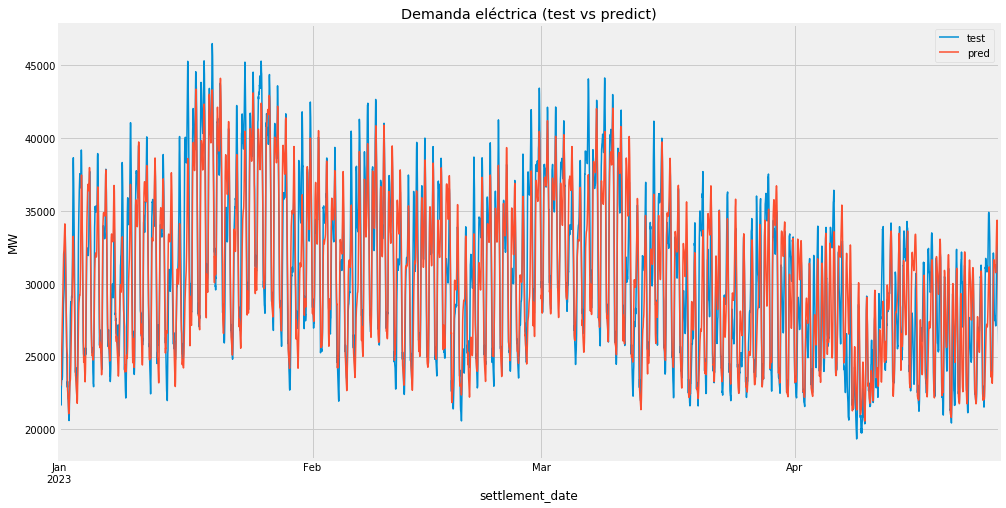

In [14]:
# gráfica: Comprobación visual de los resultados de la predicción realizada.

fig, ax = plt.subplots(figsize=(15, 8))
demand_test['tsd'].plot(ax=ax, label='test')
predicciones.loc[demand_test.index].plot(ax=ax, label='pred')
ax.set_title('Demanda eléctrica (test vs predict)')
ax.set_ylabel('MW')
ax.legend();

# Errores de las predicciones en el conjunto de test

In [15]:
# MSE: Error cuadrático medio (MSE – Mean Square Error)
# El MSE calcula la diferencia cuadrática promedio entre los valores predichos por el modelo y los valores reales observados.
# Si el valor de MSE disminuye, el ajuste del modelo a los datos será mayor.

error_mse = mean_squared_error(y_true = demand_test['tsd'], y_pred = predicciones[demand_test.index.min():demand_test.index.max()]).round(4)

print("MSE – Mean Square Error: {}".format(error_mse))

MSE – Mean Square Error: 6977874.6207


In [16]:
# RMSE: La raíz del error cuadrático medio (RMSE – Root Mean Square Error) 
# El RMSE mide el error promedio de las predicciones del modelo en unidades de la variable dependiente. Es una métrica 
# comunmente utilizada para evaluar la precisión de los modelos de regresión.

error_rmse = mean_squared_error(y_true = demand_test['tsd'], 
                y_pred = predicciones[demand_test.index.min():demand_test.index.max()],
                squared=False).round(4)

print("RMSE – Root Mean Square Error: {}".format(error_rmse))

RMSE – Root Mean Square Error: 2641.5667


In [17]:
# MAE: Error absoluto medio (MAE – Mean Absolute Error)
# El MAE mide el promedio de los errores absolutos en las predicciones del modelo. Y da la idea de la magnitud 
# promedio de los errores de predicción de los datos.

error_mae = mean_absolute_error(y_true = demand_test['tsd'], y_pred = predicciones[demand_test.index.min():demand_test.index.max()]).round(4)

print("MAE – Mean Absolute Error: {}".format(error_mae))

MAE – Mean Absolute Error: 1919.1413


In [18]:
# R2: Coeficiente de determinación
# El R-cuadrado es una métrica que indica la calidad del ajuste del modelo a los datos. Fluctúa entre 0 y 1 
# y mientras más se acerque a 1 mejor es la predicción del modelo

coef_dt = r2_score(y_true = demand_test['tsd'], y_pred = predicciones[demand_test.index.min():demand_test.index.max()]).round(4)

print("R2 - Coeficiente de determinación: {}".format(coef_dt))

R2 - Coeficiente de determinación: 0.7754


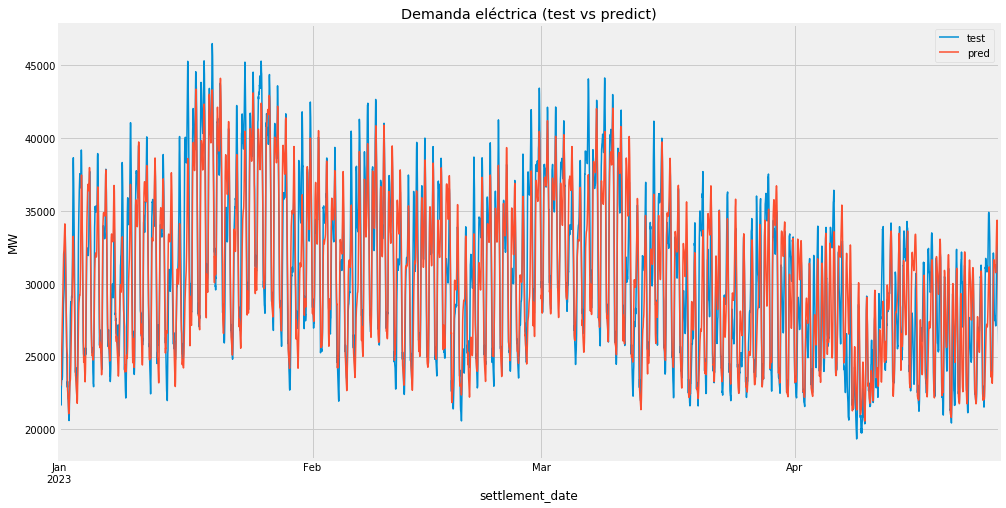

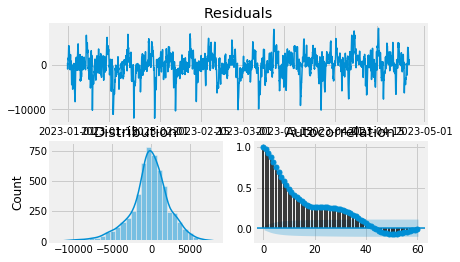

In [29]:
# RSE: Residual Standar Error
# La gráfica de residuales es una herramienta de diagnóstico que se utiliza para evaluar la calidad del ajuste de un modelo
# de regresión lineal. Se grafican los residuos del modelo (la diferencia entre los valores observados y los valores predichos
# por el modelo) en el eje vertical y los valores predichos por el modelo en el eje horizontal.
# Una buena gráfica de residuales debería mostrar una distribución aleatoria de los residuos alrededor del valor cero en el eje
# vertical. Esto indicaría que el modelo se ajusta bien a los datos y que los residuos no tienen patrones discernibles. 

pred = predicciones[demand_test.index.min():demand_test.index.max()]
residuales = pred['pred'] - demand_test['tsd']
plot_residuals(residuals=residuales, fig=fig)

# Conclusión de evaluación del modelo

In [ ]:
# El modelo de regresión lineal desarrollado para predecir la variable 'tsd' ha dado resultados satisfactorios.
# El error absoluto medio (MAE) es de 1919.1413, el error cuadrático medio (MSE) es de 6977874.6207, La raíz del error 
# cuadrático medio (RMSE) es de 2641.5667 y el coeficiente de determinación (R^2) es de 0.7754, lo que significa que el 
# modelo explica el 77.5% de la varianza en los datos.

# Ajuste de hiperparámetro del modelo

In [ ]:
# El ajuste de hiperparámetro se realiza para mejorar la predicción del modelo, agregandole algunos parámetros 
# que no pueden ser aprendidos mediante el entrenamiento. Mediante la función "grid_search_forecaster" se hace una búsqueda 
# exhaustiva sobre el conjunto de valores definidos en "lags_grid" y "param_grid" que pueda mejorar la predicción del modelo.

steps = 48  
forecaster = ForecasterAutoreg(regressor=Ridge(), lags=48, transformer_y = StandardScaler())

# Lags utilizados como predictores
lags_grid = [336, 1440]  

# Hiperparámetros del regresor
param_grid = {'alpha': np.logspace(-3, 5, 10)}

resultados_grid = grid_search_forecaster(
                        forecaster = forecaster,
                        y = demand_train['tsd'],
                        param_grid = param_grid,
                        lags_grid = lags_grid,
                        steps = steps,
                        refit = True,
                        metric = 'mean_squared_error',
                        initial_train_size = len(demand_train)-1,
                        fixed_train_size = False,
                        return_best = True,
                        n_jobs = 'auto',
                        verbose = False
                  )

resultados_grid

In [ ]:
forecaster

# Conclusión de ajuste de hiperparámetros

In [42]:
# Los mejores resultados se obtienen al utilizar los retrazos (lags): [1  2  3 ... 1438 1439 1440] y una configuración de 
# Regressor: Ridge(alpha=27.825594022071257). 
# Al indicar return_best = True en la función grid_search_forecaster(), el modelo se reentrena automáticamente con la mejor 
# configuración encontrada y el conjunto de datos completo de prueba.

# Predicción final

In [43]:
# Después de haber terminado el proceso anterior se vuelve a predecir, pero esta vez con un modelo optimizado. 
# Al finalizar se calcula el error de predicción del conjunto de datos de prueba. 

steps = 48
metrica, predicciones = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = demand['tsd'],
                            steps              = steps,
                            metric             = 'mean_absolute_error',
                            initial_train_size = len(demand_train),
                            refit              = True,  # False,
                            n_jobs             = 'auto',
                            verbose            = True,
                            show_progress      = True
                        )

print('Error de predicción: {}'.format(metrica))

Information of backtesting process
----------------------------------
Number of observations used for initial training: 23377
Number of observations used for backtesting: 227567
    Number of folds: 4741
    Number of steps per fold: 48
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 47 observations.

Fold: 0
    Training:   2009-01-01 00:00:00 -- 2010-05-03 00:00:00  (n=23377)
    Validation: 2010-05-03 00:30:00 -- 2010-05-04 00:00:00  (n=48)
Fold: 1
    Training:   2009-01-02 00:00:00 -- 2010-05-04 00:00:00  (n=23377)
    Validation: 2010-05-04 00:30:00 -- 2010-05-05 00:00:00  (n=48)
Fold: 2
    Training:   2009-01-03 00:00:00 -- 2010-05-05 00:00:00  (n=23377)
    Validation: 2010-05-05 00:30:00 -- 2010-05-06 00:00:00  (n=48)
Fold: 3
    Training:   2009-01-04 00:00:00 -- 2010-05-06 00:00:00  (n=23377)
    Validation: 2010-05-06 00:30:00 -- 2010-05-07 00:00:00  (n=48)
Fold: 4
    Training:   2009-01-05 00:00:00 -- 2010-05

    Validation: 2011-07-16 00:30:00 -- 2011-07-17 00:00:00  (n=48)
Fold: 440
    Training:   2010-03-17 00:00:00 -- 2011-07-17 00:00:00  (n=23377)
    Validation: 2011-07-17 00:30:00 -- 2011-07-18 00:00:00  (n=48)
Fold: 441
    Training:   2010-03-18 00:00:00 -- 2011-07-18 00:00:00  (n=23377)
    Validation: 2011-07-18 00:30:00 -- 2011-07-19 00:00:00  (n=48)
Fold: 442
    Training:   2010-03-19 00:00:00 -- 2011-07-19 00:00:00  (n=23377)
    Validation: 2011-07-19 00:30:00 -- 2011-07-20 00:00:00  (n=48)
Fold: 443
    Training:   2010-03-20 00:00:00 -- 2011-07-20 00:00:00  (n=23377)
    Validation: 2011-07-20 00:30:00 -- 2011-07-21 00:00:00  (n=48)
Fold: 444
    Training:   2010-03-21 00:00:00 -- 2011-07-21 00:00:00  (n=23377)
    Validation: 2011-07-21 00:30:00 -- 2011-07-22 00:00:00  (n=48)
Fold: 445
    Training:   2010-03-22 00:00:00 -- 2011-07-22 00:00:00  (n=23377)
    Validation: 2011-07-22 00:30:00 -- 2011-07-23 00:00:00  (n=48)
Fold: 446
    Training:   2010-03-23 00:00:00 -- 20

Fold: 840
    Training:   2011-04-21 00:00:00 -- 2012-08-20 00:00:00  (n=23377)
    Validation: 2012-08-20 00:30:00 -- 2012-08-21 00:00:00  (n=48)
Fold: 841
    Training:   2011-04-22 00:00:00 -- 2012-08-21 00:00:00  (n=23377)
    Validation: 2012-08-21 00:30:00 -- 2012-08-22 00:00:00  (n=48)
Fold: 842
    Training:   2011-04-23 00:00:00 -- 2012-08-22 00:00:00  (n=23377)
    Validation: 2012-08-22 00:30:00 -- 2012-08-23 00:00:00  (n=48)
Fold: 843
    Training:   2011-04-24 00:00:00 -- 2012-08-23 00:00:00  (n=23377)
    Validation: 2012-08-23 00:30:00 -- 2012-08-24 00:00:00  (n=48)
Fold: 844
    Training:   2011-04-25 00:00:00 -- 2012-08-24 00:00:00  (n=23377)
    Validation: 2012-08-24 00:30:00 -- 2012-08-25 00:00:00  (n=48)
Fold: 845
    Training:   2011-04-26 00:00:00 -- 2012-08-25 00:00:00  (n=23377)
    Validation: 2012-08-25 00:30:00 -- 2012-08-26 00:00:00  (n=48)
Fold: 846
    Training:   2011-04-27 00:00:00 -- 2012-08-26 00:00:00  (n=23377)
    Validation: 2012-08-26 00:30:00 --

Fold: 1252
    Training:   2012-06-06 00:00:00 -- 2013-10-06 00:00:00  (n=23377)
    Validation: 2013-10-06 00:30:00 -- 2013-10-07 00:00:00  (n=48)
Fold: 1253
    Training:   2012-06-07 00:00:00 -- 2013-10-07 00:00:00  (n=23377)
    Validation: 2013-10-07 00:30:00 -- 2013-10-08 00:00:00  (n=48)
Fold: 1254
    Training:   2012-06-08 00:00:00 -- 2013-10-08 00:00:00  (n=23377)
    Validation: 2013-10-08 00:30:00 -- 2013-10-09 00:00:00  (n=48)
Fold: 1255
    Training:   2012-06-09 00:00:00 -- 2013-10-09 00:00:00  (n=23377)
    Validation: 2013-10-09 00:30:00 -- 2013-10-10 00:00:00  (n=48)
Fold: 1256
    Training:   2012-06-10 00:00:00 -- 2013-10-10 00:00:00  (n=23377)
    Validation: 2013-10-10 00:30:00 -- 2013-10-11 00:00:00  (n=48)
Fold: 1257
    Training:   2012-06-11 00:00:00 -- 2013-10-11 00:00:00  (n=23377)
    Validation: 2013-10-11 00:30:00 -- 2013-10-12 00:00:00  (n=48)
Fold: 1258
    Training:   2012-06-12 00:00:00 -- 2013-10-12 00:00:00  (n=23377)
    Validation: 2013-10-12 00:3

    Training:   2013-07-08 00:00:00 -- 2014-11-07 00:00:00  (n=23377)
    Validation: 2014-11-07 00:30:00 -- 2014-11-08 00:00:00  (n=48)
Fold: 1650
    Training:   2013-07-09 00:00:00 -- 2014-11-08 00:00:00  (n=23377)
    Validation: 2014-11-08 00:30:00 -- 2014-11-09 00:00:00  (n=48)
Fold: 1651
    Training:   2013-07-10 00:00:00 -- 2014-11-09 00:00:00  (n=23377)
    Validation: 2014-11-09 00:30:00 -- 2014-11-10 00:00:00  (n=48)
Fold: 1652
    Training:   2013-07-11 00:00:00 -- 2014-11-10 00:00:00  (n=23377)
    Validation: 2014-11-10 00:30:00 -- 2014-11-11 00:00:00  (n=48)
Fold: 1653
    Training:   2013-07-12 00:00:00 -- 2014-11-11 00:00:00  (n=23377)
    Validation: 2014-11-11 00:30:00 -- 2014-11-12 00:00:00  (n=48)
Fold: 1654
    Training:   2013-07-13 00:00:00 -- 2014-11-12 00:00:00  (n=23377)
    Validation: 2014-11-12 00:30:00 -- 2014-11-13 00:00:00  (n=48)
Fold: 1655
    Training:   2013-07-14 00:00:00 -- 2014-11-13 00:00:00  (n=23377)
    Validation: 2014-11-13 00:30:00 -- 201

Fold: 2070
    Training:   2014-09-02 00:00:00 -- 2016-01-02 00:00:00  (n=23377)
    Validation: 2016-01-02 00:30:00 -- 2016-01-03 00:00:00  (n=48)
Fold: 2071
    Training:   2014-09-03 00:00:00 -- 2016-01-03 00:00:00  (n=23377)
    Validation: 2016-01-03 00:30:00 -- 2016-01-04 00:00:00  (n=48)
Fold: 2072
    Training:   2014-09-04 00:00:00 -- 2016-01-04 00:00:00  (n=23377)
    Validation: 2016-01-04 00:30:00 -- 2016-01-05 00:00:00  (n=48)
Fold: 2073
    Training:   2014-09-05 00:00:00 -- 2016-01-05 00:00:00  (n=23377)
    Validation: 2016-01-05 00:30:00 -- 2016-01-06 00:00:00  (n=48)
Fold: 2074
    Training:   2014-09-06 00:00:00 -- 2016-01-06 00:00:00  (n=23377)
    Validation: 2016-01-06 00:30:00 -- 2016-01-07 00:00:00  (n=48)
Fold: 2075
    Training:   2014-09-07 00:00:00 -- 2016-01-07 00:00:00  (n=23377)
    Validation: 2016-01-07 00:30:00 -- 2016-01-08 00:00:00  (n=48)
Fold: 2076
    Training:   2014-09-08 00:00:00 -- 2016-01-08 00:00:00  (n=23377)
    Validation: 2016-01-08 00:3

    Training:   2015-10-01 00:00:00 -- 2017-01-30 00:00:00  (n=23377)
    Validation: 2017-01-30 00:30:00 -- 2017-01-31 00:00:00  (n=48)
Fold: 2465
    Training:   2015-10-02 00:00:00 -- 2017-01-31 00:00:00  (n=23377)
    Validation: 2017-01-31 00:30:00 -- 2017-02-01 00:00:00  (n=48)
Fold: 2466
    Training:   2015-10-03 00:00:00 -- 2017-02-01 00:00:00  (n=23377)
    Validation: 2017-02-01 00:30:00 -- 2017-02-02 00:00:00  (n=48)
Fold: 2467
    Training:   2015-10-04 00:00:00 -- 2017-02-02 00:00:00  (n=23377)
    Validation: 2017-02-02 00:30:00 -- 2017-02-03 00:00:00  (n=48)
Fold: 2468
    Training:   2015-10-05 00:00:00 -- 2017-02-03 00:00:00  (n=23377)
    Validation: 2017-02-03 00:30:00 -- 2017-02-04 00:00:00  (n=48)
Fold: 2469
    Training:   2015-10-06 00:00:00 -- 2017-02-04 00:00:00  (n=23377)
    Validation: 2017-02-04 00:30:00 -- 2017-02-05 00:00:00  (n=48)
Fold: 2470
    Training:   2015-10-07 00:00:00 -- 2017-02-05 00:00:00  (n=23377)
    Validation: 2017-02-05 00:30:00 -- 201

    Training:   2016-11-02 00:00:00 -- 2018-03-04 00:00:00  (n=23377)
    Validation: 2018-03-04 00:30:00 -- 2018-03-05 00:00:00  (n=48)
Fold: 2863
    Training:   2016-11-03 00:00:00 -- 2018-03-05 00:00:00  (n=23377)
    Validation: 2018-03-05 00:30:00 -- 2018-03-06 00:00:00  (n=48)
Fold: 2864
    Training:   2016-11-04 00:00:00 -- 2018-03-06 00:00:00  (n=23377)
    Validation: 2018-03-06 00:30:00 -- 2018-03-07 00:00:00  (n=48)
Fold: 2865
    Training:   2016-11-05 00:00:00 -- 2018-03-07 00:00:00  (n=23377)
    Validation: 2018-03-07 00:30:00 -- 2018-03-08 00:00:00  (n=48)
Fold: 2866
    Training:   2016-11-06 00:00:00 -- 2018-03-08 00:00:00  (n=23377)
    Validation: 2018-03-08 00:30:00 -- 2018-03-09 00:00:00  (n=48)
Fold: 2867
    Training:   2016-11-07 00:00:00 -- 2018-03-09 00:00:00  (n=23377)
    Validation: 2018-03-09 00:30:00 -- 2018-03-10 00:00:00  (n=48)
Fold: 2868
    Training:   2016-11-08 00:00:00 -- 2018-03-10 00:00:00  (n=23377)
    Validation: 2018-03-10 00:30:00 -- 201

    Validation: 2019-04-17 00:30:00 -- 2019-04-18 00:00:00  (n=48)
Fold: 3272
    Training:   2017-12-17 00:00:00 -- 2019-04-18 00:00:00  (n=23377)
    Validation: 2019-04-18 00:30:00 -- 2019-04-19 00:00:00  (n=48)
Fold: 3273
    Training:   2017-12-18 00:00:00 -- 2019-04-19 00:00:00  (n=23377)
    Validation: 2019-04-19 00:30:00 -- 2019-04-20 00:00:00  (n=48)
Fold: 3274
    Training:   2017-12-19 00:00:00 -- 2019-04-20 00:00:00  (n=23377)
    Validation: 2019-04-20 00:30:00 -- 2019-04-21 00:00:00  (n=48)
Fold: 3275
    Training:   2017-12-20 00:00:00 -- 2019-04-21 00:00:00  (n=23377)
    Validation: 2019-04-21 00:30:00 -- 2019-04-22 00:00:00  (n=48)
Fold: 3276
    Training:   2017-12-21 00:00:00 -- 2019-04-22 00:00:00  (n=23377)
    Validation: 2019-04-22 00:30:00 -- 2019-04-23 00:00:00  (n=48)
Fold: 3277
    Training:   2017-12-22 00:00:00 -- 2019-04-23 00:00:00  (n=23377)
    Validation: 2019-04-23 00:30:00 -- 2019-04-24 00:00:00  (n=48)
Fold: 3278
    Training:   2017-12-23 00:00:0

    Validation: 2020-05-24 00:30:00 -- 2020-05-25 00:00:00  (n=48)
Fold: 3675
    Training:   2019-01-24 00:00:00 -- 2020-05-25 00:00:00  (n=23377)
    Validation: 2020-05-25 00:30:00 -- 2020-05-26 00:00:00  (n=48)
Fold: 3676
    Training:   2019-01-25 00:00:00 -- 2020-05-26 00:00:00  (n=23377)
    Validation: 2020-05-26 00:30:00 -- 2020-05-27 00:00:00  (n=48)
Fold: 3677
    Training:   2019-01-26 00:00:00 -- 2020-05-27 00:00:00  (n=23377)
    Validation: 2020-05-27 00:30:00 -- 2020-05-28 00:00:00  (n=48)
Fold: 3678
    Training:   2019-01-27 00:00:00 -- 2020-05-28 00:00:00  (n=23377)
    Validation: 2020-05-28 00:30:00 -- 2020-05-29 00:00:00  (n=48)
Fold: 3679
    Training:   2019-01-28 00:00:00 -- 2020-05-29 00:00:00  (n=23377)
    Validation: 2020-05-29 00:30:00 -- 2020-05-30 00:00:00  (n=48)
Fold: 3680
    Training:   2019-01-29 00:00:00 -- 2020-05-30 00:00:00  (n=23377)
    Validation: 2020-05-30 00:30:00 -- 2020-05-31 00:00:00  (n=48)
Fold: 3681
    Training:   2019-01-30 00:00:0

    Training:   2020-04-14 00:00:00 -- 2021-08-14 00:00:00  (n=23377)
    Validation: 2021-08-14 00:30:00 -- 2021-08-15 00:00:00  (n=48)
Fold: 4122
    Training:   2020-04-15 00:00:00 -- 2021-08-15 00:00:00  (n=23377)
    Validation: 2021-08-15 00:30:00 -- 2021-08-16 00:00:00  (n=48)
Fold: 4123
    Training:   2020-04-16 00:00:00 -- 2021-08-16 00:00:00  (n=23377)
    Validation: 2021-08-16 00:30:00 -- 2021-08-17 00:00:00  (n=48)
Fold: 4124
    Training:   2020-04-17 00:00:00 -- 2021-08-17 00:00:00  (n=23377)
    Validation: 2021-08-17 00:30:00 -- 2021-08-18 00:00:00  (n=48)
Fold: 4125
    Training:   2020-04-18 00:00:00 -- 2021-08-18 00:00:00  (n=23377)
    Validation: 2021-08-18 00:30:00 -- 2021-08-19 00:00:00  (n=48)
Fold: 4126
    Training:   2020-04-19 00:00:00 -- 2021-08-19 00:00:00  (n=23377)
    Validation: 2021-08-19 00:30:00 -- 2021-08-20 00:00:00  (n=48)
Fold: 4127
    Training:   2020-04-20 00:00:00 -- 2021-08-20 00:00:00  (n=23377)
    Validation: 2021-08-20 00:30:00 -- 202

    Training:   2021-07-08 00:00:00 -- 2022-11-07 00:00:00  (n=23377)
    Validation: 2022-11-07 00:30:00 -- 2022-11-08 00:00:00  (n=48)
Fold: 4572
    Training:   2021-07-09 00:00:00 -- 2022-11-08 00:00:00  (n=23377)
    Validation: 2022-11-08 00:30:00 -- 2022-11-09 00:00:00  (n=48)
Fold: 4573
    Training:   2021-07-10 00:00:00 -- 2022-11-09 00:00:00  (n=23377)
    Validation: 2022-11-09 00:30:00 -- 2022-11-10 00:00:00  (n=48)
Fold: 4574
    Training:   2021-07-11 00:00:00 -- 2022-11-10 00:00:00  (n=23377)
    Validation: 2022-11-10 00:30:00 -- 2022-11-11 00:00:00  (n=48)
Fold: 4575
    Training:   2021-07-12 00:00:00 -- 2022-11-11 00:00:00  (n=23377)
    Validation: 2022-11-11 00:30:00 -- 2022-11-12 00:00:00  (n=48)
Fold: 4576
    Training:   2021-07-13 00:00:00 -- 2022-11-12 00:00:00  (n=23377)
    Validation: 2022-11-12 00:30:00 -- 2022-11-13 00:00:00  (n=48)
Fold: 4577
    Training:   2021-07-14 00:00:00 -- 2022-11-13 00:00:00  (n=23377)
    Validation: 2022-11-13 00:30:00 -- 202

  0%|          | 0/4741 [00:00<?, ?it/s]

Error de predicción: 1081.9638774446423


# Conclusión de predicción final

In [44]:
# Posterior a la optimización de retrazos e hiperparámetros, se puede apreciar una reducción del error de predicción
# de 1857.92 a 1081.96.

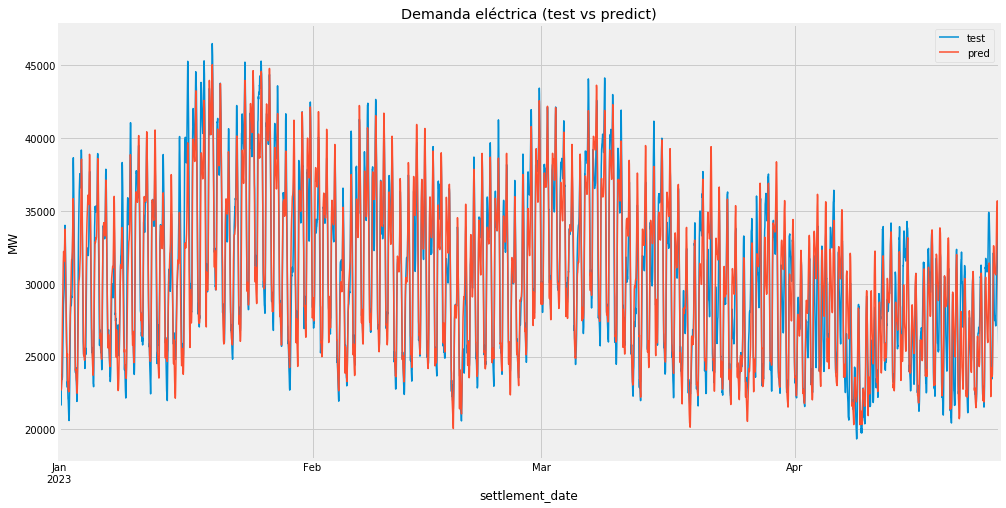

In [45]:
# gráfica

fig, ax = plt.subplots(figsize=(15, 8))
demand_test['tsd'].plot(ax=ax, label='test')
predicciones.loc[demand_test.index].plot(ax=ax, label='pred')
ax.set_title('Demanda eléctrica (test vs predict)')
ax.set_ylabel('MW')
ax.legend();

# Errores de las predicciones en el conjunto de test (final)

In [46]:
# MSE: Error cuadrático medio (MSE – Mean Square Error)
error_mse = mean_squared_error(y_true = demand_test['tsd'], y_pred = predicciones[demand_test.index.min():demand_test.index.max()]).round(4)

print("MSE – Mean Square Error: {}".format(error_mse))

MSE – Mean Square Error: 3741623.274


In [47]:
# RMSE: La raíz del error cuadrático medio (RMSE – Root Mean Square Error) 
error_rmse = mean_squared_error(y_true = demand_test['tsd'], 
                y_pred = predicciones[demand_test.index.min():demand_test.index.max()],
                squared=False).round(4)

print("RMSE – Root Mean Square Error: {}".format(error_rmse))

RMSE – Root Mean Square Error: 1934.3276


In [48]:
# MAE: Error absoluto medio (MAE – Mean Absolute Error)
error_mae = mean_absolute_error(y_true = demand_test['tsd'], y_pred = predicciones[demand_test.index.min():demand_test.index.max()]).round(4)

print("MAE – Mean Absolute Error: {}".format(error_mae))

MAE – Mean Absolute Error: 1431.8347


In [49]:
# R2: Coeficiente de determinación
coef_dt = r2_score(y_true = demand_test['tsd'], y_pred = predicciones[demand_test.index.min():demand_test.index.max()]).round(4)

print("R2 - Coeficiente de determinación: {}".format(coef_dt))

R2 - Coeficiente de determinación: 0.8796


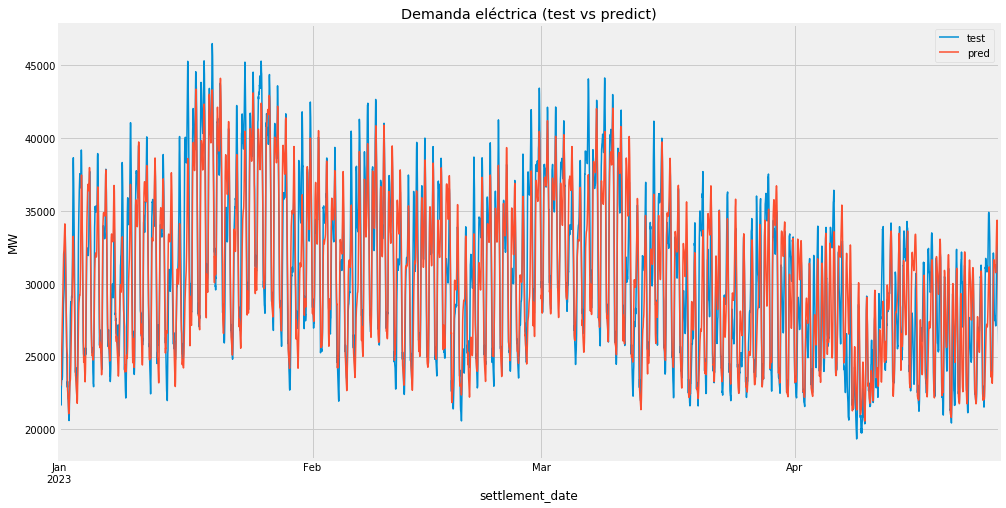

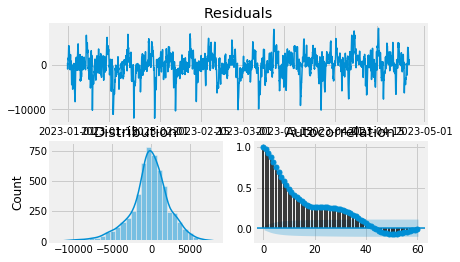

In [30]:
# RSE Residual Standar Error

pred = predicciones[demand_test.index.min():demand_test.index.max()]
residuales = pred['pred'] - demand_test['tsd']
plot_residuals(residuals=residuales, fig=fig)

# Conclusión de evaluación del modelo final

In [ ]:
# El modelo de regresión lineal desarrollado para predecir la variable 'tsd' ha mejorado sus resultados.
# El error absoluto medio (MAE) es de 1431.8347, el error cuadrático medio (MSE) es de 3741623.274, La raíz del error 
# cuadrático medio (RMSE) es de 1934.3276 y el coeficiente de determinación (R^2) es de 0.879, lo que significa que el 
# modelo final explica el 87.9% de la varianza en los datos.

In [ ]:
# Guardar modelo
save_forecaster(forecaster, file_name='forecaster.py', verbose=False)